# This file will train a network on many replicas of a set, then produce the mean CFFs found

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd 
from BHDVCS_torch import TBHDVCS

import matplotlib
import matplotlib.pyplot as plt

import sys
import time
from scipy.stats import chisquare

In [2]:
tb = TBHDVCS()

f = tb.TotalUUXS_curve_fit3
g = tb.TotalUUXS_curve_fit
loss_func = tb.loss_MSE_errs

In [3]:
dats = pd.read_csv('dvcs_psuedo.csv')
n = np.array(dats['#Set'])
ind = np.array(dats['index'])
k = np.array(dats['k'])
qq = np.array(dats['QQ'])
xb = np.array(dats['x_b'])
t = np.array(dats['t'])
phi = np.array(dats['phi_x'])
F = np.array(dats['F'])
errF = np.array(dats['errF']) 
F1 = np.array(dats['F1'])
F2 = np.array(dats['F2'])
const = np.array(dats['dvcs'])  
ReH_target = np.array(dats['ReH']) 
ReE_target = np.array(dats['ReE']) 
ReHT_target = np.array(dats['ReHtilde'])
yrep = []

errs_H = []
errs_E = []
errs_HT = []

rep_ReH = []
rep_ReE = []
rep_ReHT = []

In [4]:
blank_net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 80),
        torch.nn.Tanh(),
        torch.nn.Linear(80, 3)
    )

In [5]:
optimizer = torch.optim.Adam(blank_net.parameters(), lr=0.02)

In [6]:
EPOCH = 2500

In [8]:
reps = 10

In [9]:
fVals = np.zeros((100,36))
fitErrs = np.zeros((36))

## Training:

100.00% done with set #0.
Mean ReH for set 0 = 13.06 vs. real ReH = 13.69, error = 4.84, variance = 2.10, sigma = 0.46
Mean ReE for set 0 = -53.06 vs. real ReE = -56.46, error = 6.42, variance = 55.69, sigma = 2.36
Mean ReHT for set 0 = 7.25 vs. real ReHT = 7.01, error = 3.35, variance = 0.35, sigma = 0.19

Spread at phi = 180: 5.02e-03


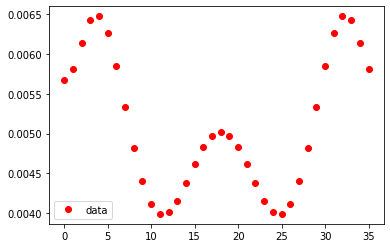

Average Sigma in Results = 5.11e-03


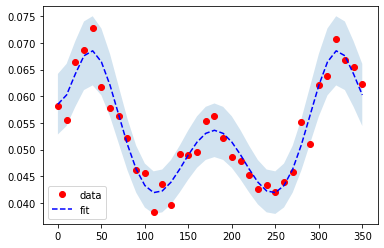

100.00% done with set #1.
Mean ReH for set 1 = 12.55 vs. real ReH = 11.38, error = 9.38, variance = 3.80, sigma = 0.62
Mean ReE for set 1 = -52.55 vs. real ReE = -45.62, error = 13.20, variance = 107.00, sigma = 3.27
Mean ReHT for set 1 = 6.97 vs. real ReHT = 7.94, error = 13.88, variance = 1.14, sigma = 0.34

Spread at phi = 180: 6.01e-03


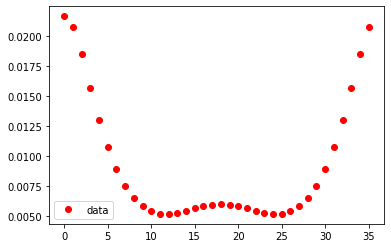

Average Sigma in Results = 9.19e-03


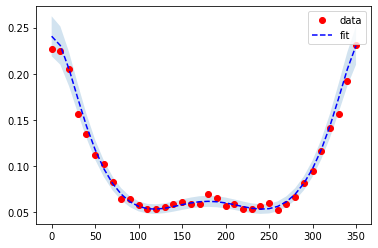

100.00% done with set #2.
Mean ReH for set 2 = 7.22 vs. real ReH = 6.06, error = 16.16, variance = 2.00, sigma = 0.45
Mean ReE for set 2 = -47.22 vs. real ReE = -40.42, error = 14.41, variance = 63.50, sigma = 2.52
Mean ReHT for set 2 = 4.01 vs. real ReHT = 4.87, error = 21.30, variance = 0.35, sigma = 0.19

Spread at phi = 180: 3.09e-03


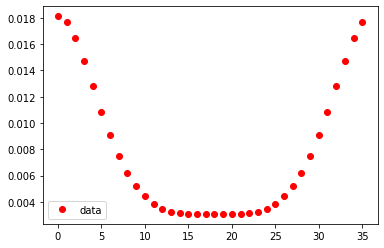

Average Sigma in Results = 7.70e-03


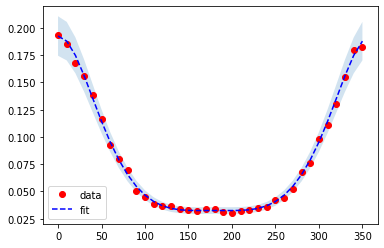

100.00% done with set #3.
Mean ReH for set 3 = 7.65 vs. real ReH = 10.28, error = 34.28, variance = 2.37, sigma = 0.49
Mean ReE for set 3 = -47.65 vs. real ReE = -60.93, error = 27.86, variance = 60.20, sigma = 2.45
Mean ReHT for set 3 = 4.25 vs. real ReHT = 4.53, error = 6.49, variance = 1.73, sigma = 0.42

Spread at phi = 180: 1.52e-03


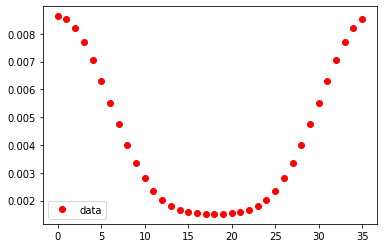

Average Sigma in Results = 4.21e-03


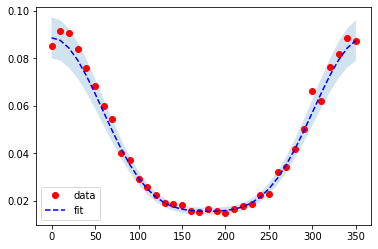

100.00% done with set #4.
Mean ReH for set 4 = 12.55 vs. real ReH = 11.98, error = 4.54, variance = 0.45, sigma = 0.21
Mean ReE for set 4 = -52.55 vs. real ReE = -49.19, error = 6.39, variance = 10.73, sigma = 1.04
Mean ReHT for set 4 = 6.97 vs. real ReHT = 7.39, error = 5.92, variance = 0.27, sigma = 0.16

Spread at phi = 180: 3.24e-03


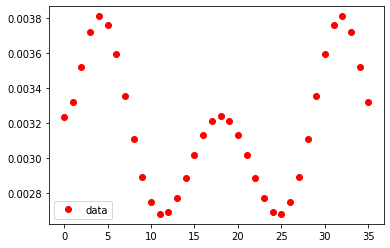

Average Sigma in Results = 3.19e-03


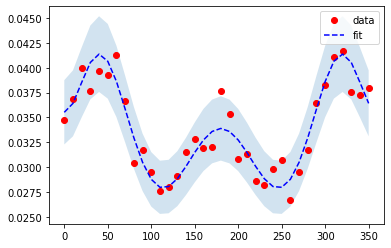

100.00% done with set #5.
Mean ReH for set 5 = 7.22 vs. real ReH = 6.94, error = 3.98, variance = 3.34, sigma = 0.58
Mean ReE for set 5 = -47.22 vs. real ReE = -45.55, error = 3.56, variance = 112.34, sigma = 3.35
Mean ReHT for set 5 = 4.01 vs. real ReHT = 4.46, error = 11.08, variance = 0.41, sigma = 0.20

Spread at phi = 180: 1.92e-03


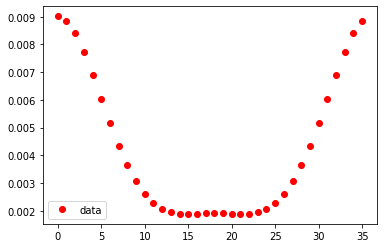

Average Sigma in Results = 4.23e-03


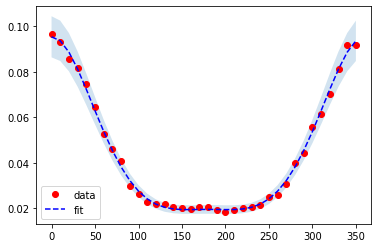

100.00% done with set #6.
Mean ReH for set 6 = 11.74 vs. real ReH = 10.31, error = 12.23, variance = 10.92, sigma = 1.05
Mean ReE for set 6 = -51.74 vs. real ReE = -43.47, error = 15.98, variance = 347.16, sigma = 5.89
Mean ReHT for set 6 = 6.52 vs. real ReHT = 7.27, error = 11.49, variance = 2.10, sigma = 0.46

Spread at phi = 180: 3.49e-03


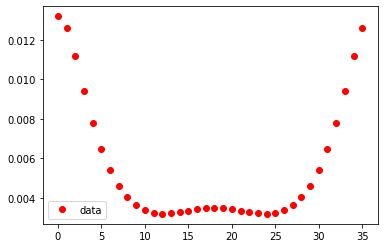

Average Sigma in Results = 5.56e-03


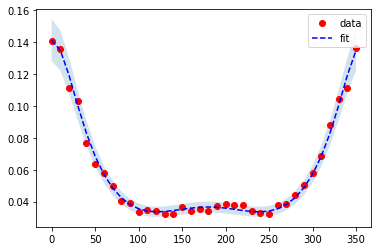

97.26% done with set #7.

In [ ]:
for datset in range(14):
    rep_ReH = []
    rep_ReE = []
    rep_ReHT = []
    rep_ReH.clear()
    rep_ReE.clear()
    rep_ReHT.clear()
    
    i = datset
    a = 36*i # start index of set
    b = a+36 # end index of set

    for j in range(reps): # create n replicas
        start = time.time()
        net = blank_net # untrain/reset network

        yrep = [0] * (b-a) # create array to be filled with replicated F values

        for l in range(b-a): # populate yrep with random normal values with mean = F and sd = errF

            yind = a+l # index of data point 
            yrep[l] = (np.random.normal(F[yind], errF[yind]))


        xdat = np.array([phi[a:b], qq[a:b], xb[a:b], t[a:b], k[a:b], F1[a:b], F2[a:b], const[a:b]])
        ydat = np.array(yrep)

        x = Variable(torch.from_numpy(xdat[1:5].transpose()))
        y = Variable(torch.from_numpy(ydat.transpose()))

        xdat = Variable(torch.from_numpy(xdat))

        errs = Variable(torch.from_numpy(errF[a:b]))

        for epoch in range(EPOCH):

            p = net(x.float()) #output arrays for 3 predicted values for cffs

            hs = torch.transpose(p, 0, 1)[0] # array of 36 values for ReH at each increment of phi
            es = torch.transpose(p, 0, 1)[1] # array of 36 values for ReE at each increment of phi
            hts = torch.transpose(p, 0, 1)[2] # array of 36 values for ReHT at each increment of phi

            ReHfit = torch.mean(hs)
            ReEfit = torch.mean(es)
            ReHTfit = torch.mean(hts)

            cffs = [ReHfit, ReEfit, ReHTfit]

            loss = loss_func((xdat.float()), cffs, errs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pctdone = ((float(2500*(j)+epoch)*100)/float(reps*EPOCH))
            sys.stdout.write("\r%.2f%% done with set #%d." % ((pctdone, i)))
            sys.stdout.flush()

        fVals[j] = g(xdat.float(), hs.data.numpy(), es.data.numpy(), hts.data.numpy())

        ReHfit = torch.mean(torch.transpose(p, 0, 1)[0]).data.numpy()
        ReEfit = torch.mean(torch.transpose(p, 0, 1)[1]).data.numpy()
        ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2]).data.numpy()
        fit_cffs = [ReHfit, ReEfit, ReHTfit]

    #     plt.plot(phi[a:b], F[a:b], 'ro', label='data')
    #     plt.plot(phi[a:b], f(xdat,fit_cffs), 'b--', label='fit')
    #     plt.legend()
    #     plt.show()

        rep_ReH.append(ReHfit)
        rep_ReE.append(ReEfit)
        rep_ReHT.append(ReHTfit)

    #     print("\nReH on replica %d: %.2f vs real ReH: %.2f. Error = %.2f" % (j, cffs[0], ReH_target[a], abs(100*(abs(np.mean(rep_ReH)-ReH_target[a]))/ReH_target[a])))
    #     print("ReE on replica %d: %.2f vs real ReE: %.2f. Error = %.2f" % (j, cffs[1], ReE_target[a], abs(100*(abs(np.mean(rep_ReE)-ReE_target[a]))/ReE_target[a])))
    #     print("ReHT on replica %d: %.2f vs real ReHT: %.2f. Error = %.2f" % (j, cffs[2], ReHT_target[a], abs(100*(abs(np.mean(rep_ReHT)-ReHT_target[a]))/ReHT_target[a])))

    rep_ReH = np.array(rep_ReH)
    rep_ReE = np.array(rep_ReE)
    rep_ReHT = np.array(rep_ReHT)

    err_H = abs(100*(abs(np.mean(rep_ReH)-ReH_target[a]))/ReH_target[a])
    err_E = abs(100*(abs(np.mean(rep_ReE)-ReE_target[a]))/ReE_target[a])
    err_HT = abs(100*(abs(np.mean(rep_ReHT)-ReHT_target[a]))/ReHT_target[a])
    
    print('\nMean ReH for set %d = %.2f vs. real ReH = %.2f, error = %.2f, variance = %.2f, sigma = %.2f' % (i, ReH_target[a] ,np.mean(rep_ReH), err_H, np.var(rep_ReH), np.sqrt(np.var(rep_ReH))/np.sqrt(reps)))
    print('Mean ReE for set %d = %.2f vs. real ReE = %.2f, error = %.2f, variance = %.2f, sigma = %.2f' % (i, ReE_target[a], np.mean(rep_ReE), err_E, np.var(rep_ReE), np.sqrt(np.var(rep_ReE))/np.sqrt(reps)))
    print('Mean ReHT for set %d = %.2f vs. real ReHT = %.2f, error = %.2f, variance = %.2f, sigma = %.2f\n' % (i, ReHT_target[a], np.mean(rep_ReHT), err_HT, np.var(rep_ReHT), np.sqrt(np.var(rep_ReHT))/np.sqrt(reps)))

    vals = np.transpose(fVals)

    for fspr in range(len(vals)):
        fitErrs[fspr] = np.sqrt(np.var(vals[fspr]))/np.sqrt(reps)
        
    print("Spread at phi = 180: %.2e" % (fitErrs[18]))
    plt.plot(fitErrs, 'ro', label='data')
    plt.legend()
    plt.show()
    
    print("Average Sigma in Results = %.2e" % np.mean(np.abs(np.asarray(fitErrs))))

    plt.plot(phi[a:b], F[a:b], 'ro', label='data')
    plt.plot(phi[a:b], f(xdat,fit_cffs), 'b--', label='fit')
    plt.fill_between(phi[a:b], f(xdat,fit_cffs)-fitErrs, f(xdat,fit_cffs)+fitErrs, alpha = 0.2)
    plt.legend()
    plt.show()